<a href="https://colab.research.google.com/github/nikogarro/Deep-Learning/blob/main/tf_image_class_pretrained_models_malaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction and Set-up

TensorFlow Datasets has many datasets that can be loaded and be used to learn more about image classification and various computer vision machine learning pipelines. It is a great way to learn more about TensorFlow and the architecture of computer vision models in general. This tutorial will go over the importance of data exploration as well as all the steps for a image classification machine learning problem.

In [1]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
#from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import scipy
import gc

print(tf.__version__)
print(tfds.__version__)

2.14.0
4.9.3


# Initial Exploration

We will be using the TFDS Malaria dataset. The Malaria dataset is contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells from the thin blood smear slide images of segmented cells. The original data source is from [NIH](https://lhncbc.nlm.nih.gov/publication/pub9932). A big aspect of machine learning is data processing. Feature engineering and normalizing data is important. Correctly formatted data will help the model train better and make better inferences about the data.

## Loading the data

We'll be using TFDS Malaria dataset for our example. It is quite easy to load the data using TFDS API.

# Model building

## Loading images

We first want to load our images into three different datasets: a training dataset, a validation dataset, and a training dataset.

In [2]:
BATCH_SIZE = 64
IMAGE_SIZE = (224, 224)

train_ds, val_ds, test_ds = tfds.load('malaria',
                                      split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
                                      shuffle_files=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteOAK8MQ/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


We will divide our data into 70:15:15 ratio. We can check that our ratios are correct by checking how many images are in each dataset.

In [3]:
NUM_TRAIN_IMAGES = tf.data.experimental.cardinality(train_ds).numpy()
print("Num training images: " + str(NUM_TRAIN_IMAGES))

NUM_VAL_IMAGES = tf.data.experimental.cardinality(val_ds).numpy()
print("Num validating images: " + str(NUM_VAL_IMAGES))

NUM_TEST_IMAGES = tf.data.experimental.cardinality(test_ds).numpy()
print("Num testing images: " + str(NUM_TEST_IMAGES))

Num training images: 19291
Num validating images: 4133
Num testing images: 4134


## Reshape image input

Let's see the shapes of our images.

In [4]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (103, 103, 3)
Label:  0


Not all the images are of size (200, 200). Thankfully, TensorFlow Image API has a way to resize images by either cropping big pictures or padding smaller ones. Let's define our padding method.

In [5]:
def convert(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32)
  return image, label

def pad(image,label):
  image,label = convert(image, label)
  image = tf.image.resize_with_crop_or_pad(image, 224, 224)
  return image,label

We have to use `.map()` to apply our padding method to all of our images. While we are at it, we should batch our images.

In [6]:
padded_train_ds = (
    train_ds
    .cache()
    .map(pad)
    .batch(BATCH_SIZE)
)

padded_val_ds = (
    val_ds
    .cache()
    .map(pad)
    .batch(BATCH_SIZE)
)

## Visualize padded images

In [8]:
image_batch, label_batch = next(iter(padded_train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("uninfected")
        else:
            plt.title("parasitized")
        plt.axis("off")

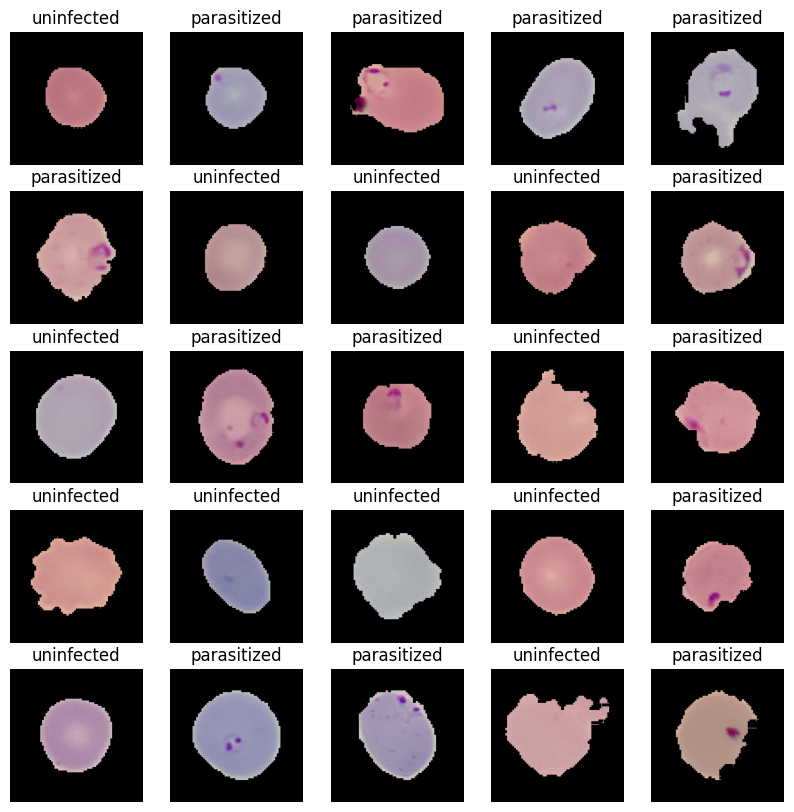

In [9]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

padded_train_ds = padded_train_ds.prefetch(buffer_size=AUTOTUNE)
padded_val_ds = padded_val_ds.prefetch(buffer_size=AUTOTUNE)

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.2, fill_mode='nearest'),
])

In [21]:
image_batch, label_batch = next(iter(padded_train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(data_augmentation(image_batch[n]))
        if label_batch[n]:
            plt.title("uninfected")
        else:
            plt.title("parasitized")
        plt.axis("off")

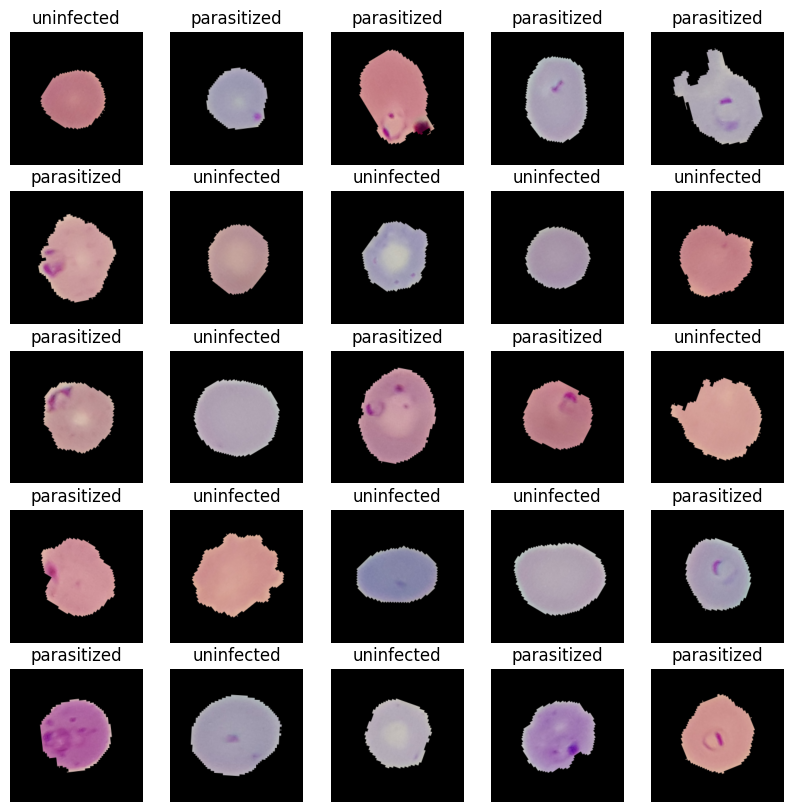

In [22]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [8]:
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, EfficientNetB0, VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [9]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [10]:
IMAGE_SIZE = (224, 224)

In [11]:
IMG_SHAPE = IMAGE_SIZE + (3,)
base_model1 = VGG16(input_shape=IMG_SHAPE, include_top=False,
                                               weights='imagenet')

58889256/58889256 [==============================] - 0s 0us/step


In [12]:
base_model1.trainable = False

In [13]:
base_model1.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
inputs = tf.keras.Input(shape=(224, 224, 3))
#x = data_augmentation(inputs)
x = base_model1(inputs, training=False)
x = tf.keras.layers.Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)
model1 = tf.keras.Model(inputs, outputs)

In [15]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 40406849 (154.14 MB)
Trainable params: 25692161

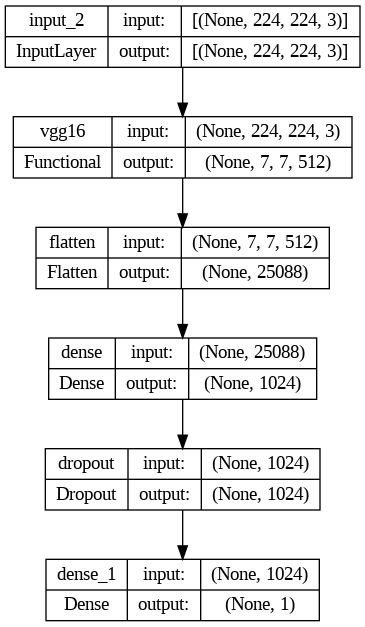

In [16]:
tf.keras.utils.plot_model(model1, show_shapes=True)

In [17]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("malaria_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     restore_best_weights=True)

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.001, 10)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [17]:
from tensorflow.keras.optimizers import Adam

In [18]:
base_learning_rate = 0.0001
model1.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=tf.keras.metrics.AUC(name='auc'))

In [19]:
padded_test_ds = (
     test_ds
    .cache()
    .map(pad)
    .batch(BATCH_SIZE)
)

In [20]:
initial_epochs = 10
epoch = 10
loss0, accuracy0 = model1.evaluate(padded_test_ds)

65/65 [==============================] - 35s 275ms/step - loss: 0.7507 - auc: 0.6663


In [21]:
history1 = model1.fit(
    padded_train_ds, epochs=initial_epochs,
    validation_data=padded_val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

Epoch 1/10
302/302 [==============================] - ETA: 0s - loss: 0.5301 - auc: 0.9084

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


302/302 [==============================] - 99s 314ms/step - loss: 0.5301 - auc: 0.9084 - val_loss: 0.1801 - val_auc: 0.9821 - lr: 0.0010
Epoch 2/10
302/302 [==============================] - 91s 301ms/step - loss: 0.1991 - auc: 0.9754 - val_loss: 0.1728 - val_auc: 0.9842 - lr: 7.9433e-04
Epoch 3/10
302/302 [==============================] - 97s 322ms/step - loss: 0.1805 - auc: 0.9794 - val_loss: 0.1551 - val_auc: 0.9858 - lr: 6.3096e-04
Epoch 4/10
 75/302 [======>.......................] - ETA: 55s - loss: 0.1719 - auc: 0.9809

KeyboardInterrupt: ignored

In [81]:
def graph(history, model):
    acc = history.history['accuracy']
    test_acc = history.history['val_accuracy']

    loss = history.history['loss']
    test_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(test_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy for ' + model)

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(test_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0, 10.0])
    plt.title('Training and Validation Loss for ' + model)
    plt.xlabel('epoch')
    plt.show()

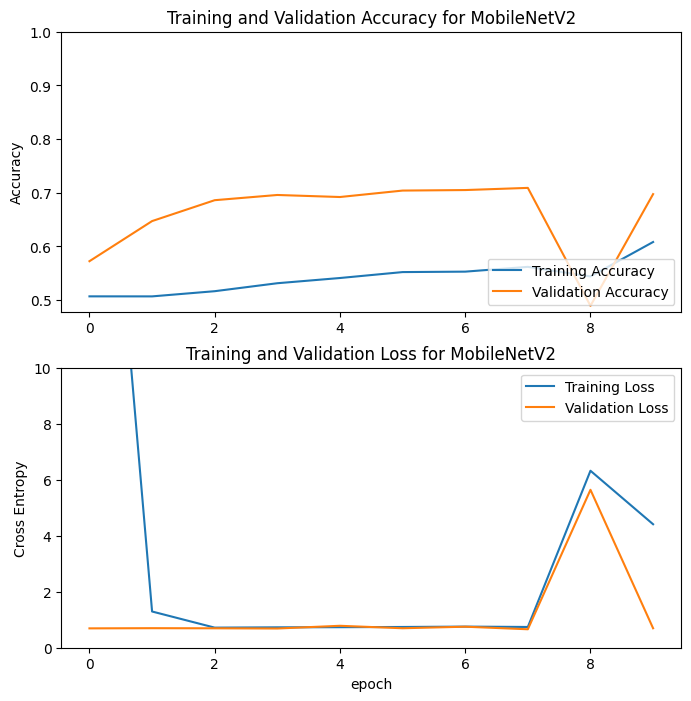

In [82]:
graph(history1, 'MobileNetV2')

In [83]:
base_model1.trainable = True

In [84]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model1.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model1.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  19


In [85]:
model1.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              loss="binary_crossentropy",
              metrics=tf.keras.metrics.AUC(name='auc'))

In [86]:
model1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_10 (Dense)            (None, 1024)              2569

In [87]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

In [88]:
history_fine1 = model1.fit(
    padded_train_ds, epochs=total_epochs,
    initial_epoch=history1.epoch[-1],
    validation_data=padded_val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

Epoch 10/20
603/603 [==============================] - 99s 162ms/step - loss: 22.0469 - auc: 0.5224 - val_loss: 3.3399 - val_auc: 0.5187 - lr: 0.0035
Epoch 11/20
603/603 [==============================] - 98s 162ms/step - loss: 15.2162 - auc: 0.5252 - val_loss: 0.6689 - val_auc: 0.7137 - lr: 0.0032
Epoch 12/20
603/603 [==============================] - 98s 162ms/step - loss: 9.8497 - auc: 0.5275 - val_loss: 0.6629 - val_auc: 0.7142 - lr: 0.0028
Epoch 13/20
603/603 [==============================] - 94s 155ms/step - loss: 7.3845 - auc: 0.5298 - val_loss: 1.1934 - val_auc: 0.7123 - lr: 0.0025
Epoch 14/20
603/603 [==============================] - 94s 155ms/step - loss: 5.4635 - auc: 0.5366 - val_loss: 4.4090 - val_auc: 0.5000 - lr: 0.0022
Epoch 15/20
603/603 [==============================] - 98s 163ms/step - loss: 3.8606 - auc: 0.5367 - val_loss: 0.7024 - val_auc: 0.7143 - lr: 0.0020
Epoch 16/20
603/603 [==============================] - 94s 156ms/step - loss: 2.9676 - auc: 0.5403 - val

In [89]:
acc = history1.history['accuracy']
test_acc = history1.history['val_accuracy']

loss = history1.history['loss']
test_loss = history1.history['val_loss']

In [90]:
def fine_tuned_graph(history_fine, acc, test_acc, loss, test_loss, model):
    acc += history_fine.history['accuracy']
    test_acc += history_fine.history['val_accuracy']

    loss += history_fine.history['loss']
    test_loss += history_fine.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(test_acc, label='Validation Accuracy')
    plt.ylim([0.5, 1])
    plt.plot([initial_epochs-1,initial_epochs-1],
        plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy for ' + model)

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(test_loss, label='Validation Loss')
    plt.ylim([0, 10.0])
    plt.plot([initial_epochs-1,initial_epochs-1],
        plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss for ' + model)
    plt.xlabel('epoch')
    plt.show()

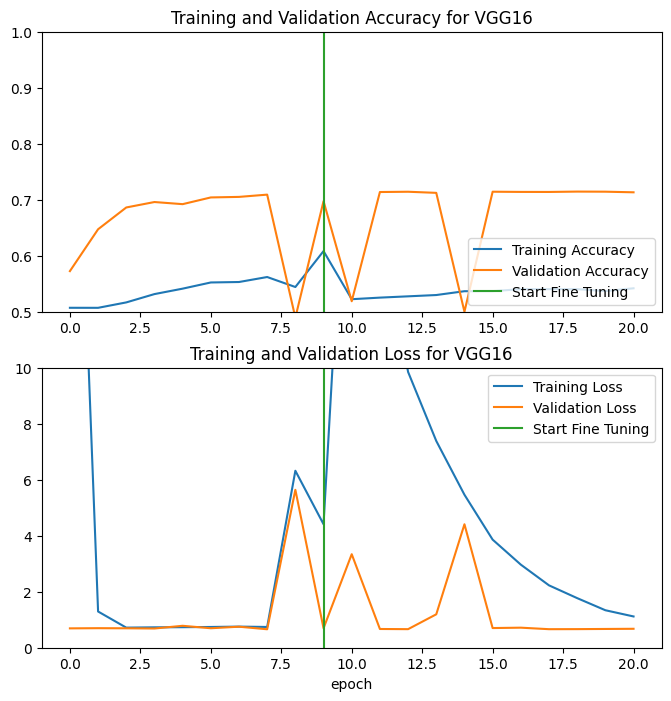

In [91]:
fine_tuned_graph(history_fine1, acc, test_acc, loss, test_loss, 'VGG16')

In [92]:
loss, accuracy = model1.evaluate(padded_test_ds)
print('Test accuracy :', accuracy)

130/130 [==============================] - 17s 127ms/step - loss: 0.6756 - auc: 0.7149
Test accuracy : 0.7148799896240234


In [93]:
class_names = train_ds.class_names

AttributeError: ignored

Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0]


NameError: ignored

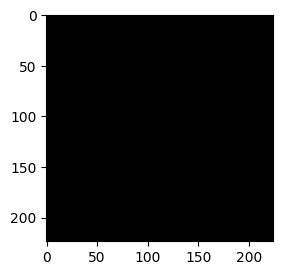

In [94]:
# Retrieve a batch of images from the test set
image_batch, label_batch = padded_test_ds.as_numpy_iterator().next()
predictions = model1.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  true_label = class_names[label_batch[i]]  # Get the true label
  predicted_label = class_names[predictions[i]]  # Get the predicted label
  title = f"True: {true_label}\nPredicted: {predicted_label}"
  plt.title(title)
  plt.axis("off")

In [95]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

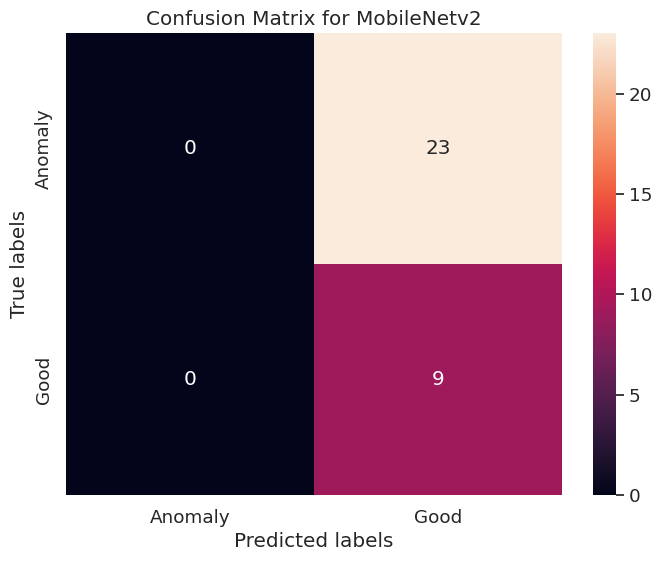

              precision    recall  f1-score   support

     Anomaly      0.000     0.000     0.000        23
        Good      0.281     1.000     0.439         9

    accuracy                          0.281        32
   macro avg      0.141     0.500     0.220        32
weighted avg      0.079     0.281     0.123        32



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [96]:
# Retrieve a batch of images from the test set
image_batch, label_batch = padded_test_ds.as_numpy_iterator().next()
predictions = model1.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

confusion_mat = confusion_matrix(label_batch, predictions)
class_labels = ["Anomaly", "Good"]  # Replace with your class labels

# Create a Seaborn heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion_mat, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for MobileNetv2')
plt.show()

print(classification_report(label_batch, predictions, digits=3, target_names=['Anomaly', 'Good']))

## Build our model

Let's build our deep CNN. We will be using the TensorFlow Keras API for easy implementation.

We'll create two blocks, one convolution block and one dense block so we won't have to repeat our code.

In [97]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )

    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

Now we'll define our model. We want our last layer to be a dense layer with a single node. The closer the value is to 1, the higher likelihood that the image is uninfected. Values closer to 0 indice a higher probability of being parasitized.

In [98]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

As we are working on a binary classification problem, we will be using a binary crossentropy loss function. Additionally, this data, luckily, is balanced. This means that half of the images are parasitized and half the images are uninfected. Because we are working with a balanced dataset, we will be using AUC-ROC as our metric. To learn more about AUC-ROC, check out this [resource](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc).

In [99]:
model = build_model()

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=tf.keras.metrics.AUC(name='auc')
)

## Callbacks

We want to define certain callbacks so that we have the best model without overfitting.

One of the most important hyperparameters is the learning rate. A learning rate that is too high will prevent the model from converging. Conversely, a learning rate that is too slow will cause the training process to be too long and take up unnecessary resources. We'll be using an exponential decay function to change our learning rate for each epoch.

The checkpoint and early stopping callback saves the best weights for the model and stops the model once it stops improving. This will slow down overfitting and save time.

In [100]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("malaria_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     restore_best_weights=True)

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

## Training

In [101]:
history = model.fit(
    padded_train_ds, epochs=20,
    validation_data=padded_val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

Epoch 1/20
603/603 [==============================] - ETA: 0s - loss: 0.6669 - auc: 0.6570

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


603/603 [==============================] - 130s 119ms/step - loss: 0.6669 - auc: 0.6570 - val_loss: 0.7417 - val_auc: 0.7118 - lr: 0.0100
Epoch 2/20
105/603 [====>.........................] - ETA: 50s - loss: 0.5994 - auc: 0.7453

KeyboardInterrupt: ignored

## Evaluate results

First let's preprocess our testing images.

In [ ]:
padded_test_ds = (
     test_ds
    .cache()
    .map(pad)
    .batch(BATCH_SIZE)
)

In [ ]:
model.evaluate(padded_test_ds)

We see that our model has an AUC-ROC score of . A high AUC-ROC shows that our model works well at differentiating between parasitized and uninfected cells.

In [ ]:
model.summary()